# Load package

In [ ]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import drive

# Database Input

## Water withdrawal profiles

In [ ]:
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/CEE272R_workingspace/Raw_Water_Profiles'
indices = [0, 7, 18]
file_names = [f"ewh_profile[{i}].csv" for i in indices]

# Initialize an empty DataFrame to store all data
all_profiles_df = pd.DataFrame()

# Load and process each file
for index, file in zip(indices, file_names):
    full_path = os.path.join(folder_path, file)
    if os.path.exists(full_path):
        df = pd.read_csv(full_path, usecols=['Winter_Timestamps', 'Winter_Water_Consumption', 'Winter_Ambient_Temperature'])
        df['Winter_Timestamps'] = pd.to_datetime(df['Winter_Timestamps'])
        df['Winter_Water_Consumption'] /= 60000  # Convert unit from L/min to m3/s
        df = df.sort_values(by='Winter_Timestamps')

        # Select data only for the first five days
        start_date = df['Winter_Timestamps'].min()
        end_date = start_date + pd.Timedelta(days=5)
        df = df[(df['Winter_Timestamps'] >= start_date) & (df['Winter_Timestamps'] < end_date)]

        # Resample data at a 15-minute interval
        df.set_index('Winter_Timestamps', inplace=True)
        resampled_df = df.resample('15T').agg({
            'Winter_Water_Consumption': 'mean',  # Sum up the water consumption
        }).reset_index()

        # Add an index identifier to column names
        resampled_df.columns = [f"{col}_idx{index}" if col != 'Winter_Timestamps' else 'Winter_Timestamps' for col in resampled_df.columns]

        # Merge into the overall DataFrame
        if all_profiles_df.empty:
            all_profiles_df = resampled_df
        else:
            all_profiles_df = pd.merge(all_profiles_df, resampled_df, on='Winter_Timestamps', how='outer')

# Check the merged DataFrame
print(all_profiles_df.head())


Mounted at /content/drive
    Winter_Timestamps  Winter_Water_Consumption_idx0  \
0 2017-07-25 00:00:00                            0.0   
1 2017-07-25 00:15:00                            0.0   
2 2017-07-25 00:30:00                            0.0   
3 2017-07-25 00:45:00                            0.0   
4 2017-07-25 01:00:00                            0.0   

   Winter_Water_Consumption_idx7  Winter_Water_Consumption_idx18  
0                            0.0                             0.0  
1                            0.0                             0.0  
2                            0.0                             0.0  
3                            0.0                             0.0  
4                            0.0                             0.0  


## Input load data

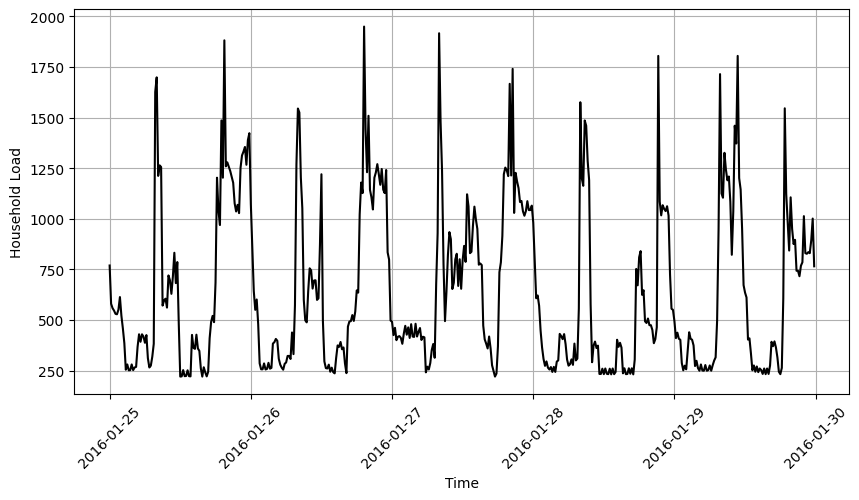

                      local_15min    grid
598092  2016-01-25 00:00:00-06:00   769.0
598093  2016-01-25 00:15:00-06:00   580.0
598094  2016-01-25 00:30:00-06:00   558.0
598095  2016-01-25 00:45:00-06:00   546.0
598096  2016-01-25 01:00:00-06:00   530.0
...                           ...     ...
598567  2016-01-29 22:45:00-06:00   835.0
598568  2016-01-29 23:00:00-06:00   830.0
598569  2016-01-29 23:15:00-06:00   893.0
598570  2016-01-29 23:30:00-06:00  1001.0
598571  2016-01-29 23:45:00-06:00   765.0

[480 rows x 2 columns]


In [ ]:
# input load data
loadfolder_path = '/content/drive/My Drive/CEE272R_workingspace/15minute_data_california'
file_path = f'{loadfolder_path}/15minute_data_california.csv'

# Load the CSV file
data_15min = pd.read_csv(file_path)


# Filter data_15min by dataid and selected columns
selected_columns = ['local_15min', 'grid']


# Define the date range
start_date = pd.Timestamp('2016-1-25 00:00:00-06')
end_date = pd.Timestamp('2016-1-30 00:00:00-06')


load_df = data_15min.loc[data_15min['dataid'] ==9775,selected_columns]

# Ensure 'local_15min' is a datetime type for filtering
load_df['local_15min'] = pd.to_datetime(load_df['local_15min'], errors='coerce')
load_df['grid'] *= 1000

# Filter based on the date range
load_df = load_df[(load_df['local_15min'] >= start_date) & (load_df['local_15min'] < end_date)]


plt.figure(0,figsize=(10,5))
plt.plot(load_df['local_15min'],load_df['grid'],color='black')
plt.xticks(rotation = 45)
plt.xlabel('Time')
plt.ylabel('Household Load')
plt.grid()
plt.show()


print(load_df)


## Input Solar Profile


https://pvwatts.nrel.gov/

DC System Size (kW): 4 ! (panel10* **400w**)

Module Type: Standard

Array Type: Fixed (open rack)

System Losses (%): 14.08

Tilt (deg): 20

Azimuth (deg): 180

DC to AC Size Ratio: 1.2

Inverter Efficiency (%): 96

Ground Coverage Ratio: 0.4

In [ ]:



# Define the path to the solar data file
solarfolder_path = '/content/drive/My Drive/CEE272R_workingspace/Solar_Profiles'
file_path = f'{solarfolder_path}/pvwatts_hourly.csv'


solar = pd.read_csv(file_path,usecols=['Ambient Temperature (C)', 'AC System Output (W)'])
solar.index = pd.date_range(start='2016-01-25 00:00',periods=len(solar), freq='H')
solar_resampled = solar.resample('15T').interpolate(method='linear')


# Select for the columns 'Ambient Temperature (C)' and 'AC System Output (W)'
solar_resampled['AC System Output (W)'] *= 0.7
solar_resampled['Ambient Temperature (C)'] +=  273.15

# Print the first few rows to verify the changes
solar_resampled = solar_resampled.iloc[:-1]

solar_resampled = solar_resampled.reset_index(drop=True)

## Merge Dataframe

In [ ]:
merged_df = load_df
merged_df['local_15min'] = pd.to_datetime(merged_df['local_15min'], errors='coerce')


merged_df = merged_df.reset_index(drop=True)
merged_df = merged_df.join(solar_resampled['Ambient Temperature (C)'])
merged_df = merged_df.join(solar_resampled['AC System Output (W)'])
merged_df = merged_df.join(all_profiles_df.iloc[:, 1:])


merged_df.columns = ['Date & Time', 'Load[W]', 'Ambient_Temperature[K]','Solar[W]','Winter_Water_Consumption_S0','Winter_Water_Consumption_S1','Winter_Water_Consumption_S2']
print(merged_df)

                  Date & Time  Load[W]  Ambient_Temperature[K]  Solar[W]  \
0   2016-01-25 00:00:00-06:00    769.0                  287.15       0.0   
1   2016-01-25 00:15:00-06:00    580.0                  287.15       0.0   
2   2016-01-25 00:30:00-06:00    558.0                  287.15       0.0   
3   2016-01-25 00:45:00-06:00    546.0                  287.15       0.0   
4   2016-01-25 01:00:00-06:00    530.0                  287.15       0.0   
..                        ...      ...                     ...       ...   
475 2016-01-29 22:45:00-06:00    835.0                  284.15       0.0   
476 2016-01-29 23:00:00-06:00    830.0                  284.15       0.0   
477 2016-01-29 23:15:00-06:00    893.0                  284.15       0.0   
478 2016-01-29 23:30:00-06:00   1001.0                  284.15       0.0   
479 2016-01-29 23:45:00-06:00    765.0                  284.15       0.0   

     Winter_Water_Consumption_S0  Winter_Water_Consumption_S1  \
0                     

In [ ]:


water_usage = []

for i in range(3):
    column_name = f'Winter_Water_Consumption_S{i}'
    # Check if the column exists in the DataFrame to avoid KeyError
    if column_name in merged_df.columns:

        total_water = merged_df[column_name].sum()
        water_use = total_water * 15 * 60  # 15 minutes * 60 seconds
        water_usage.append(water_use)

# Print the list of water usage values
print(water_usage)


[0.7865, 0.9585, 0.89875]


In [ ]:
def plot_data(df,y,z):
    plt.figure(0,figsize=(10,5))
    plt.plot(df['Date & Time'],df[y],color='black')
    start_time = pd.Timestamp('2016-01-24 18:00:00-0600')
    end_time = merged_df['Date & Time'].iloc[-1]
    delta = pd.Timedelta(hours=6)
    tick_positions = pd.date_range(start=start_time, end=end_time, freq=delta)
    formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
    ax = plt.gca()
    ax.set_xticks(tick_positions)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=30)
    plt.xlabel('Time')
    plt.ylabel(z)
    plt.show()



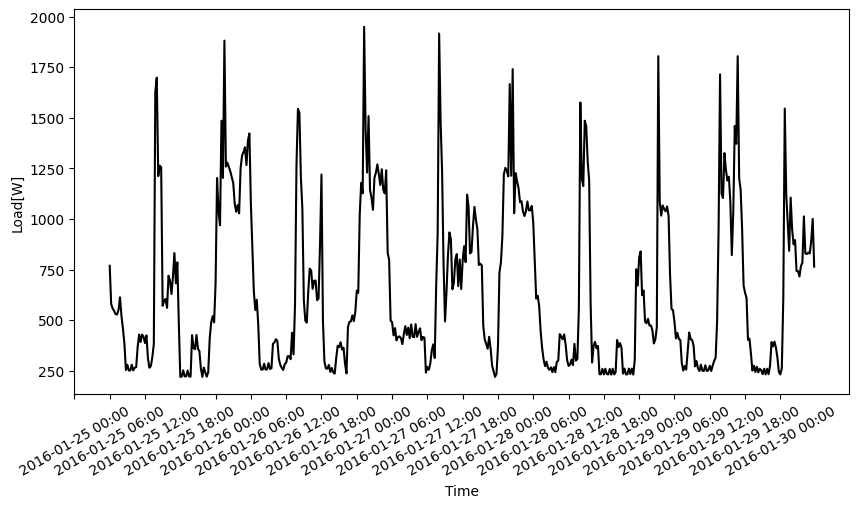

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_data(merged_df,'Load[W]','Load[W]')
plt.savefig('f1.png', dpi=300)

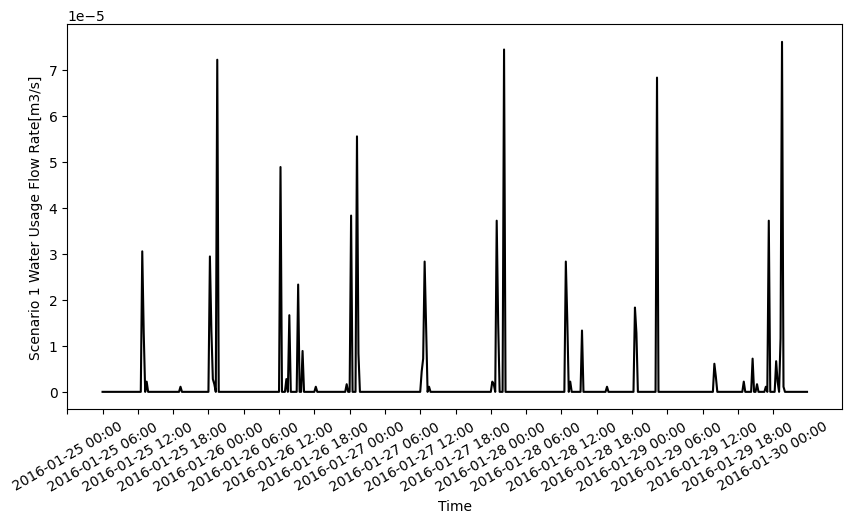

In [ ]:
plot_data(merged_df,'Winter_Water_Consumption_S0','Scenario 1 Water Usage Flow Rate[m3/s]')

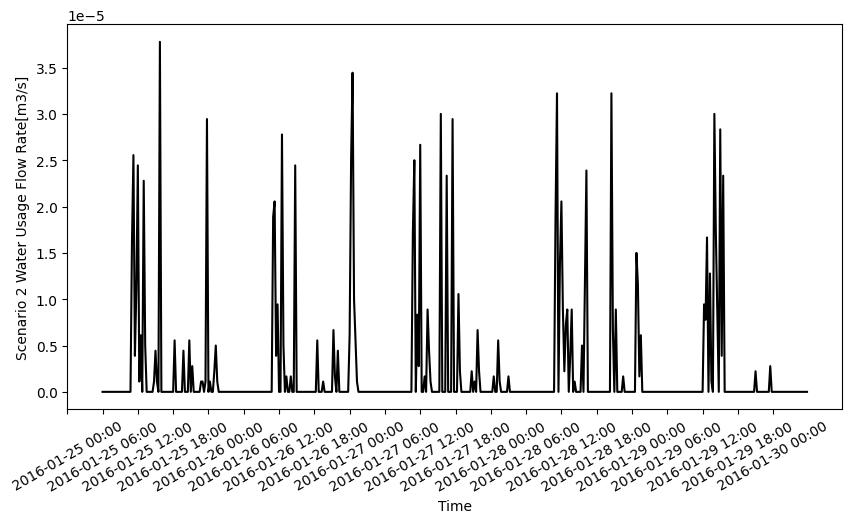

In [ ]:
plot_data(merged_df,'Winter_Water_Consumption_S1','Scenario 2 Water Usage Flow Rate[m3/s]')

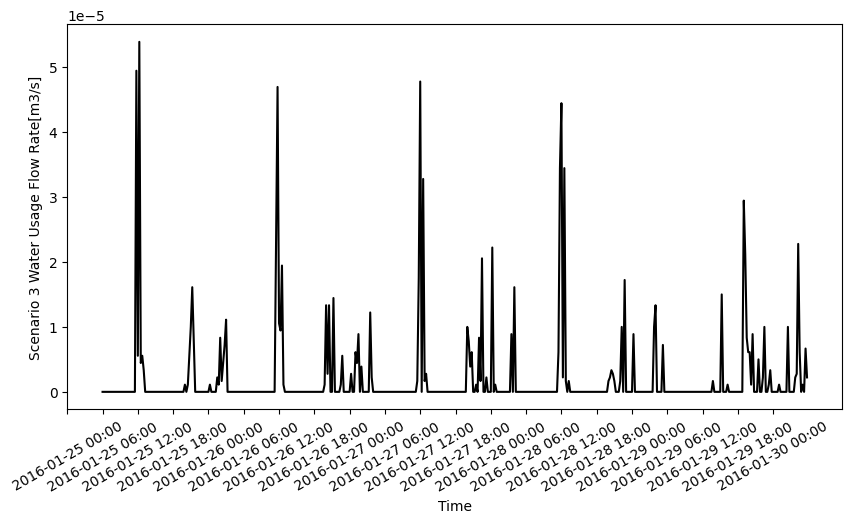

In [ ]:
plot_data(merged_df,'Winter_Water_Consumption_S2','Scenario 3 Water Usage Flow Rate[m3/s]')

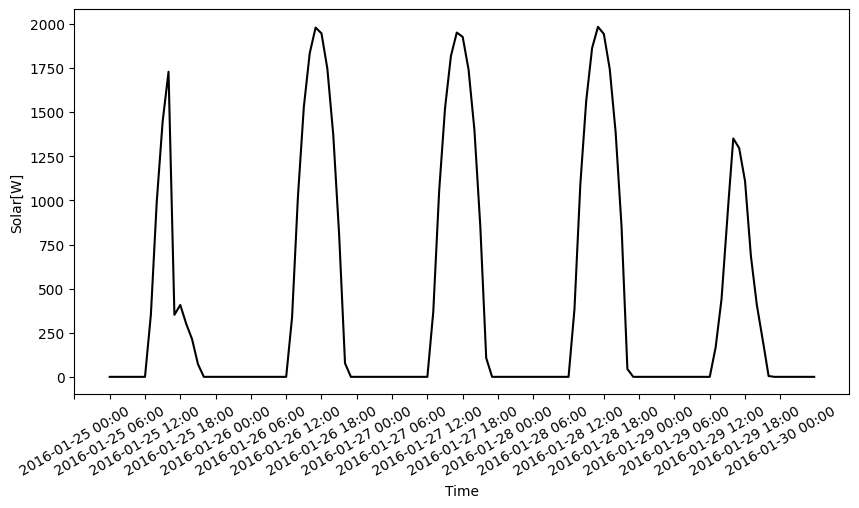

In [ ]:
plot_data(merged_df,'Solar[W]','Solar[W]')

# CVX

## Basic Parameter Setup

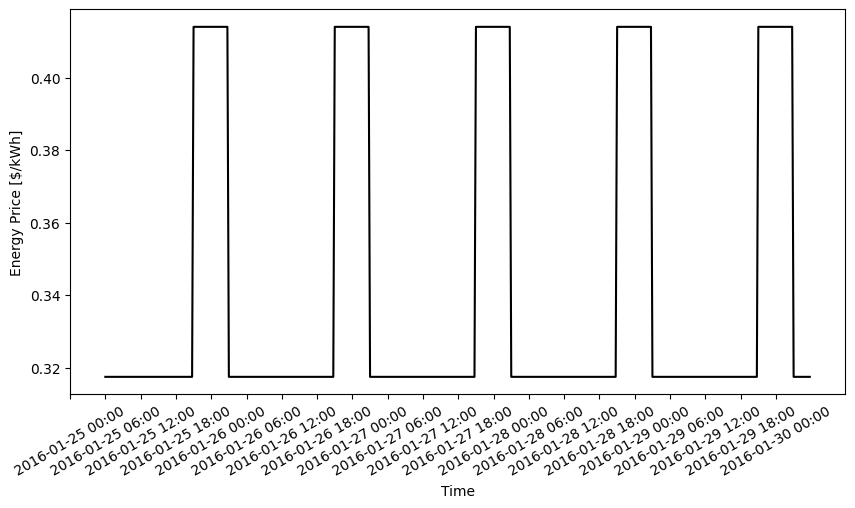

In [ ]:
# Peak Price

Peak_Price = 0.41406 #[$/kWh]
Offpeak_Price = 0.36749-0.05 #[$/kWh]
merged_df['Energy Price [$/kWh]'] = np.NaN
merged_df.loc[(merged_df['Date & Time'].dt.hour>=15) & (merged_df['Date & Time'].dt.hour<21),'Energy Price [$/kWh]'] = Peak_Price
merged_df.loc[(merged_df['Date & Time'].dt.hour<15) | (merged_df['Date & Time'].dt.hour>=21),'Energy Price [$/kWh]'] = Offpeak_Price
plot_data(merged_df,'Energy Price [$/kWh]','Energy Price [$/kWh]')

In [ ]:
# Basic Parameters
delta_t = 15*60 #[s]
timesteps = len(merged_df['Date & Time'])


# Water Heater Parameters
H_coff = 3.24
T_low = 318.15 # [K] 113F 45C
T_high = 333.15 # [K] 140F 60C
initial_temperature = (T_high + T_low) / 2
T_in = 283.15  # [K] inlet water temperature 10C
U = 1.27  # [W/K] Thermal conductance of the tank insulation
V= 0.189271 #[m3] 50 gal
C= 4181.3 * 1000 * V  # [J/K] water heat capacity
p_heater_max =700

## CVXPY problem setting with solar


Water Profiles Scenario 0:
Cost after shift loading is 23.28 $/m3


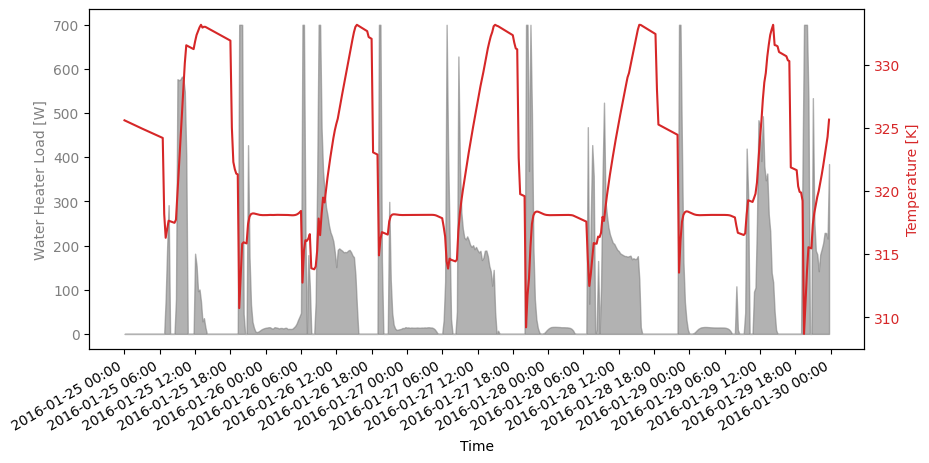

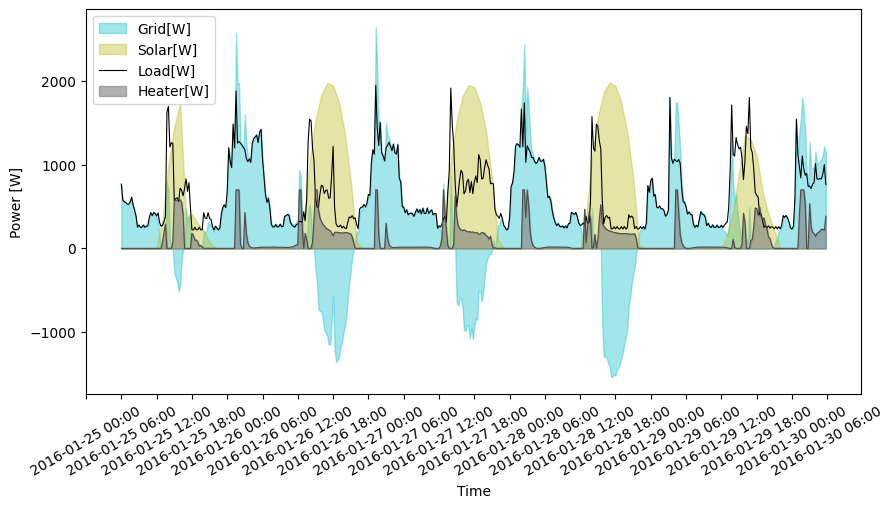

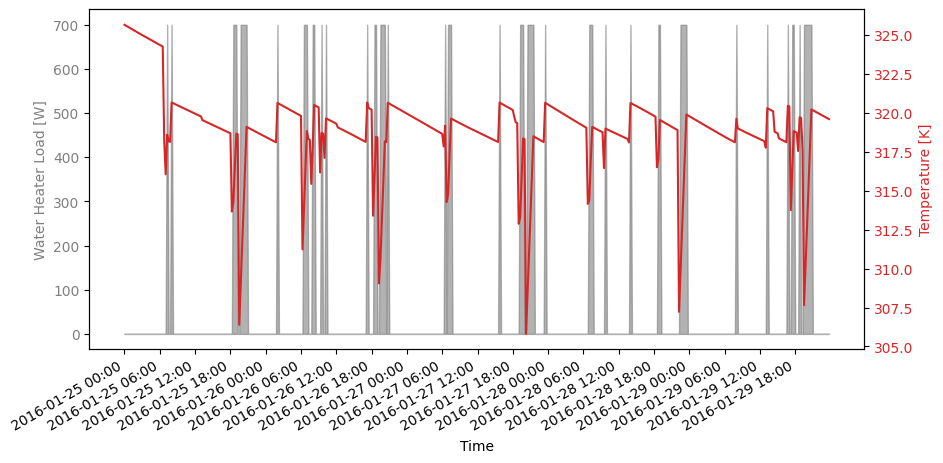

Cost before shift loading is 25.03 $/m3
Cost saving from shift loading is 1.75 $/m3 per day

Water Profiles Scenario 1:
Cost after shift loading is 18.98 $/m3


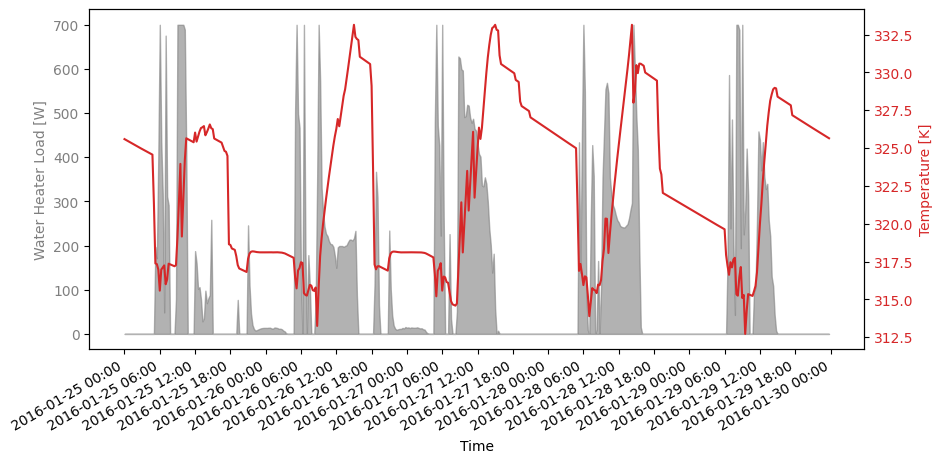

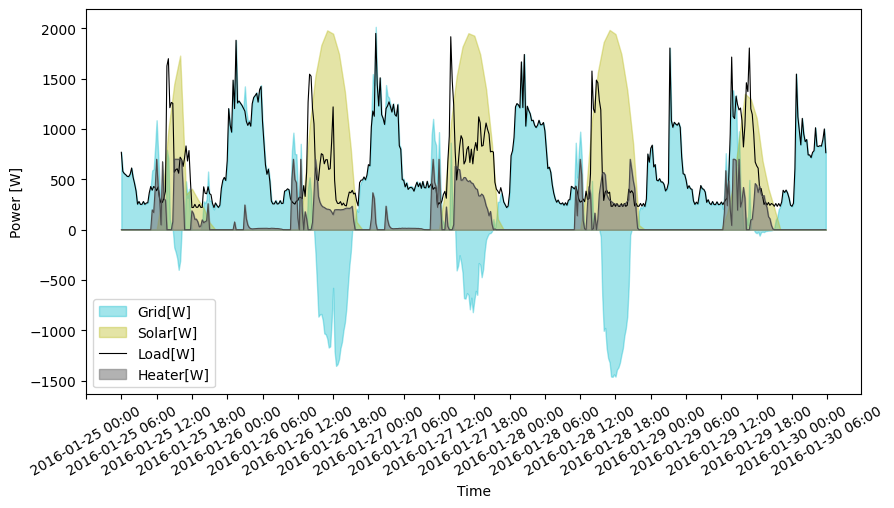

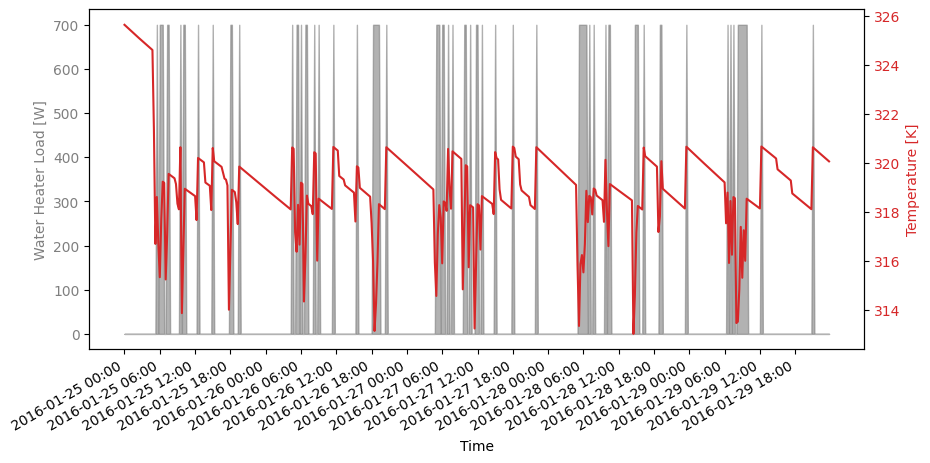

Cost before shift loading is 20.38 $/m3
Cost saving from shift loading is 1.39 $/m3 per day

Water Profiles Scenario 2:
Cost after shift loading is 20.43 $/m3


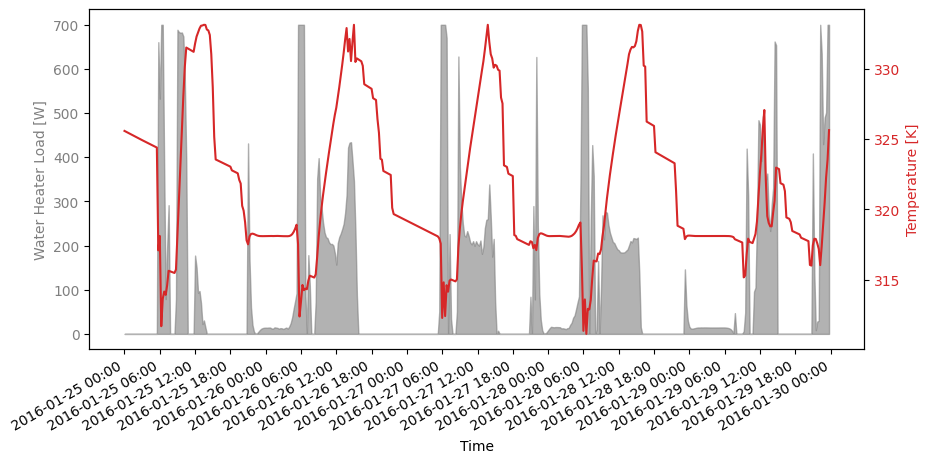

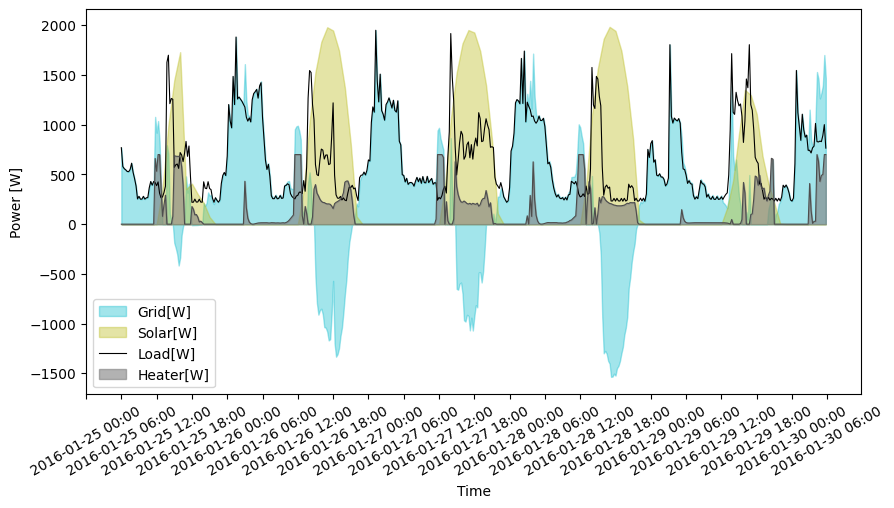

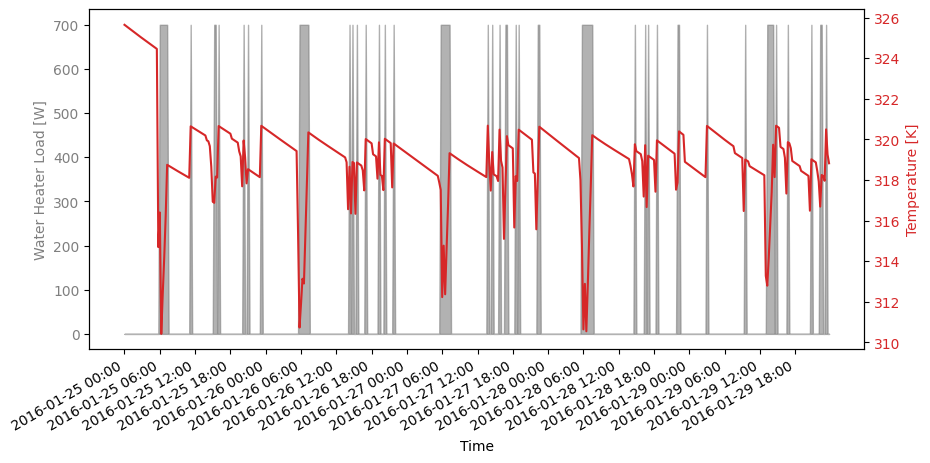

Cost before shift loading is 21.91 $/m3
Cost saving from shift loading is 1.48 $/m3 per day


In [ ]:
cost_before=[]
cost_saving=[]
cost_after=[]
for s in range(3):

  print()
  print(f'Water Profiles Scenario {s}:')
  # initialize variables
  p_heater = cp.Variable((timesteps, 1))  #power consumed by water heater at T
  p_grid = cp.Variable((timesteps, 1)) # net metering at T
  Temp = cp.Variable((timesteps + 1, 1)) # Temperature at T

  energy_price = np.array([merged_df['Energy Price [$/kWh]'].values]).T
  sell_price = np.array([merged_df['Energy Price [$/kWh]'].values]).T*0.25
  load = np.array([merged_df['Load[W]'].values]).T
  T_a = np.array([merged_df['Ambient_Temperature[K]'].values]).T
  solar = np.array([merged_df['Solar[W]'].values]).T
  water = np.array([merged_df[f'Winter_Water_Consumption_S{s}'].values]).T#set objective (obj) for cost
  obj = cp.Minimize(energy_price.T/1000/3600 @ cp.maximum(p_grid,0) * delta_t
                    # - sell_price.T/1000/3600 @ cp.minimum(p_grid,0) * delta_t
                    + 4e-4 * cp.sum(cp.square(cp.maximum(T_low - Temp[:-1], 0))))

  constraints = [
      p_heater >= 0,
      p_heater <= p_heater_max,
      Temp[0,0] == initial_temperature,
      Temp[-1,0] == initial_temperature,
      p_grid + solar == p_heater + load,
      Temp[:-1] <= T_high,  # Hard upper temperature bound for all timesteps
      Temp[1:] == Temp[:-1] + delta_t / C * (p_heater * H_coff + U * (T_a - Temp[:-1]))+ delta_t/V* cp.multiply(water,(T_in - Temp[:-1]))]
  #solve the CVX problem (objective variable should be named obj)
  prob = cp.Problem(obj, constraints)
  prob.solve(solver=cp.ECOS)

  total_cost=energy_price.T/1000/3600 @ cp.maximum(p_grid,0) * delta_t+ sell_price.T/1000/3600 @ cp.minimum(p_grid,0)* delta_t

  cost_value = total_cost.value[0][0]/water_usage[s]
  cost_after.append(cost_value)
  print(f'Cost after shift loading is {cost_value:.2f} $/m3')


  fig, ax1 = plt.subplots(figsize=(10, 5))
  # Plotting the water heater load on the right y-axis with filled area
  color = 'tab:gray'
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Water Heater Load [W]', color=color)

  ax1.fill_between(merged_df['Date & Time'], 0, p_heater.value.flatten(), color=color, alpha=0.6)
  ax1.tick_params(axis='y', labelcolor=color)

  start_time = merged_df['Date & Time'].min()
  end_time = pd.Timestamp('2016-01-30 0:00:00-0600')
  ticks = pd.date_range(start=start_time, end=end_time, freq='6H')
  ax1.set_xticks(ticks)
  ax1.set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in ticks], rotation=60)
  fig.autofmt_xdate()

  # Plotting the water temperature
  ax2 = ax1.twinx()
  red_color = 'tab:red'
  ax2.set_ylabel('Temperature [K]', color=red_color)
  ax2.plot(merged_df['Date & Time'], Temp[1:].value, color=red_color, label='Temperature [K]')
  ax2.tick_params(axis='y', labelcolor=red_color)

  plt.show()

  # Plot 2
  plt.figure(0,figsize=(10,5))
  plt.fill_between(merged_df['Date & Time'], 0, p_grid.value.flatten(), color='tab:cyan', alpha=0.4,label='Grid[W]')
  plt.fill_between(merged_df['Date & Time'], 0, merged_df['Solar[W]'], color='tab:olive', alpha=0.4,label='Solar[W]')
  plt.plot(merged_df['Date & Time'], merged_df['Load[W]'], color = 'k', label='Load[W]',linewidth=0.8)
  plt.plot(merged_df['Date & Time'], p_heater.value, color = '0.3',linewidth=0.8)
  plt.fill_between(merged_df['Date & Time'], 0, p_heater.value.flatten(), color='tab:grey', alpha=0.6,label='Heater[W]')


  start_time = pd.Timestamp('2016-01-24 18:00:00-0600')
  end_time = merged_df['Date & Time'].iloc[-1]
  delta = pd.Timedelta(hours=6)
  tick_positions = pd.date_range(start=start_time, end=pd.Timestamp('2016-01-30 0:00:00-0600'), freq=delta)
  formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
  ax = plt.gca()
  ax.set_xticks(tick_positions)
  ax.xaxis.set_major_formatter(formatter)

  plt.xticks(rotation=30)
  plt.xlabel('Time')
  plt.ylabel('Power [W]')
  plt.legend()
  plt.show()

  # Different water profiles
  water_list = merged_df[f'Winter_Water_Consumption_S{s}']
  energy_price_list = merged_df['Energy Price [$/kWh]']
  sell_price_list = merged_df['Energy Price [$/kWh]']*0.25

  # Initial conditions
  n = len(merged_df['Load[W]'])  # Number of timesteps based on data length
  temperature = np.full(n, initial_temperature)
  p_heater_list= np.zeros(n)

  # Simulation loop
  for i in range(1, n):
      # Update the power of the heater
      if temperature[i-1] < T_low:
          p_heater_list[i] = p_heater_max  # Turn on the heater
      elif temperature[i-1] > T_high:
          p_heater_list[i] = 0  # Turn off the heater

      # Calculate the temperature at the next timestep
      heat_added = p_heater_list[i] * H_coff
      heat_lost = U * (merged_df['Ambient_Temperature[K]'][i] - temperature[i-1])
      cooling_from_incoming_water = water_list[i] * (T_in - temperature[i-1])
      temperature[i] = temperature[i-1] + delta_t / C * (heat_added + heat_lost) + delta_t / V * cooling_from_incoming_water

  # Output results (optional, for debugging or analysis)
  # You can save the results or plot them depending on your needs
  p_grid_list = p_heater_list + merged_df['Load[W]']- merged_df['Solar[W]']

  fig, ax1 = plt.subplots(figsize=(10, 5))

  # Plot water temperature on the left y-axis
  color = 'tab:gray'
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Water Heater Load [W]', color=color)

  ax1.fill_between(merged_df['Date & Time'], 0, p_heater_list.flatten(), color=color, alpha=0.6)
  ax1.tick_params(axis='y', labelcolor=color)

  ticks = pd.date_range(start=start_time, end=end_time, freq='6H')
  ax1.set_xticks(ticks)
  ax1.set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in ticks], rotation=60)

    # Plotting the water temperature
  ax2 = ax1.twinx()
  red_color = 'tab:red'
  ax2.set_ylabel('Temperature [K]', color=red_color)
  ax2.plot(merged_df['Date & Time'], temperature.flatten(), color=red_color, label='Temperature [K]')
  ax2.tick_params(axis='y', labelcolor=red_color)


  fig.autofmt_xdate()


  # Set title and legend

  plt.show()

  cost_to_buy = (energy_price_list / 1000 / 3600* delta_t) * np.maximum(p_grid_list, 0)
  revenue_from_selling = (sell_price_list / 1000 / 3600 * delta_t) * np.minimum(p_grid_list, 0)

  # Total cost
  total_cost_baseline = np.sum(cost_to_buy + revenue_from_selling)/water_usage[s]
  cost_before.append(total_cost_baseline)
  print(f'Cost before shift loading is {total_cost_baseline:.2f} $/m3')
  #!!!
  per_unit_cost_saving= total_cost_baseline-cost_value
  cost_saving.append(per_unit_cost_saving)
  print(f'Cost saving from shift loading is {(per_unit_cost_saving):.2f} $/m3 per day')




In [ ]:
eresult = pd.DataFrame({
    'Water Profiles Scenario': [f'Water Profiles Scenario {s}' for s in range(3)],
    'cost_before': cost_before,
    'cost_after': cost_after,
    'cost_saving': cost_saving,
})

# Display the DataFrame
print(result)